## **SIMS Tutorial**
In this tutorial, we will walk through the [SIMS (Scalable, Interpretable Machine Learning for Single Cell)](https://www.cell.com/cell-genomics/fulltext/S2666-979X(24)00165-4) pipeline step by step. SIMS is a deep learning-based tool built on TabNet, a transformer-based model optimized for tabular data. It is designed to classify single-cell RNA sequencing (scRNA-seq) data while providing interpretable predictions.

By following this tutorial, you will learn how to:
- Download and prepare scRNA-seq data for SIMS
- Train a SIMS model to classify cell types
- Use the trained model to make predictions on new, unseen data
- Evaluate predictions using accuracy metrics and visualization tools




### **Before you begin**
The `scsims` package is only compatible with Python versions between 3.8 and 3.11. Run the following cell to ensure you are using a compatible version (we recommend Python 3.9 for optimal performance).

In [1]:
!python --version

Python 3.9.6


If you're running this notebook for the first time, uncomment and execute the following line to **install the required packages:**

In [12]:
# !pip install --use-pep517 git+https://github.com/braingeneers/SIMS.git

Once the packages are installed, we can **import them:**

In [17]:
import scanpy as sc
import pandas as pd
import anndata as ad
import os
import torch
from scsims import SIMS
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

### **Step 1: Prepare data**

Before we can train our model, we need to prepare the data. This involves several key steps to ensure that the dataset is structured correctly and optimized for machine learning.

#### `1.a` Download data
The dataset we are using comes from a study published in eLife by Domingo-Gonzalez et al. (2020). This study investigated immune cells in the developing mouse lung at single-cell resolution. It contains only 4,052 cells, making it ideal for this notebook (large enough for meaningful training but small enough for computational efficiency).

🔗 Source:

- [UCSC Cell Browser website](https://cells.ucsc.edu/?bp=lung&org=Mouse+(M.+musculus)) – where we download the dataset.
- [Domingo-Gonzalez et al., 2020 (eLife)](https://elifesciences.org/articles/56890) – original study providing the data.

In [3]:
!curl -O https://cells.ucsc.edu/mouse-lung-immune/exprMatrix.tsv.gz
!curl -O https://cells.ucsc.edu/mouse-lung-immune/meta.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.1M  100 24.1M    0     0  3239k      0  0:00:07  0:00:07 --:--:-- 3581k --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  748k  100  748k    0     0  2052k      0 --:--:-- --:--:-- --:--:-- 2057k


#### `1.b` Load the Anndata object
In this step, we will load the gene expression matrix and associated metadata, clean the data, and convert it into an AnnData object for further processing.

In [4]:
# Load expression matrix
expr_matrix = pd.read_csv("exprMatrix.tsv.gz", sep="\t", index_col=0)

# Load metadata
meta = pd.read_csv("meta.tsv", sep="\t", index_col=0)

# This particular dataset stores gene names in a 'GENE|GENE' format
# This step removes duplicate gene names if they exist
if "|" in expr_matrix.index[0]:
    expr_matrix.index = expr_matrix.index.str.split('|').str[0]

# Transpose to make cells as rows and genes as columns (CELL x GENE)
expr_matrix = expr_matrix.T

# Ensure indices match
expr_matrix = expr_matrix.loc[meta.index]

# Create AnnData object
adata = ad.AnnData(expr_matrix)

# Add metadata to AnnData object
adata.obs = meta

# Show basic info
print(adata)

AnnData object with n_obs × n_vars = 4052 × 18072
    obs: 'title', 'Sequencing run', 'Gender', 'Plate', 'Well', 'Timepoint', 'Cell Subtype', 'Mousename', 'Coverage', 'Number of genes', 'raw file 1', 'raw file 2'


#### `1.c` Select target feature
In this example dataset, cell type labels are stored in the 'Cell Subtype' column, so we will remove other columns as they are not needed for training.

🔹 **Note:** If you're using a different dataset, replace 'Cell Subtype' with the appropriate column that contains your cell type annotations. Run `adata.obs.columns` to check available columns in your dataset before selecting the target feature.

In [5]:
class_label = 'Cell Subtype' 

adata.obs = adata.obs[[class_label]] # Filter out other columns
unique_classes = adata.obs[class_label].unique()
print("Cell types: ", unique_classes)

Cell types:  ['NK cell' 'T cell' 'B cell' 'Mac III' 'neutrophil' 'IL cell' 'Mac V'
 'basophil' 'Mac II' 'mast cell' 'Mac IV' 'DC III' 'DC II' 'DC I' 'Mac I']


#### `1.d` Preprocess the data
Now we need to preprocess the data to ensure it is clean, normalized, and ready for model training. 

🔹 **Important:** The same preprocessing steps must be applied consistently to both the training dataset and any new data used for inference to ensure compatibility.

In [6]:
# Perform some light filtering
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

# Transform the data for model ingestion
sc.pp.normalize_total(adata) 
sc.pp.log1p(adata)
sc.pp.scale(adata)

#### `1.e` Split data
In real-world applications, SIMS is typically used with two datasets: a **labeled** dataset for training and an **unlabeled** dataset for generating predictions. Since we don't have a separate unlabeled dataset for this example, we'll split our labeled dataset into a **training set** (used to train the model) and a **test set** (used to evaluate its performance). This allows us to assess how well SIMS generalizes to unseen data.

🔹 **Note:** If you are using your own dataset, do not split it. Instead, load your test data separately during the prediction step. Make sure to preprocess your test data using the same steps applied to your training data to maintain consistency and avoid errors.

In [7]:
# Split cells into train and test (ex: 80% train, 20% test)
train_cells, test_cells = train_test_split(adata.obs_names, test_size=0.2, random_state=42)

# Create training and "unlabeled" test datasets
adata_train = adata[train_cells].copy()
adata_test = adata[test_cells].copy()

### **Step 2: Train the model with SIMS**
Now that our dataset is preprocessed, we can train a machine learning model using SIMS. SIMS is built on [TabNet](https://arxiv.org/abs/1908.07442), a deep learning architecture optimized for tabular data. It allows us to classify immune cells based on gene expression while maintaining model interpretability.

#### `2.a` Initialize SIMS model
We first create a SIMS object using the training dataset (`adata_train`) and specify the cell type label column:

In [8]:
sims = SIMS(data=adata_train, class_label=class_label)

Numerically encoding class labels
Calculating weights


#### `2.b` Set up model parameters
Next, we configure the model using setup_model():

In [9]:
sims.setup_model(n_a=64, n_d=64, weights=sims.weights)

Setting up model ...
Initializing network
Initializing explain matrix


- `n_a=64` and `n_d=64` define the number of attention and decision steps in the TabNet architecture.
- `weights=sims.weights` ensures that the model adjusts for imbalanced cell types by weighting the loss inversely to label frequency. This helps the model learn rare cell types more effectively.

#### `2.c` Define Checkpointing Strategy
Since training deep learning models takes time, we save the best version using a checkpointing system:

In [10]:
checkpoint_callback = ModelCheckpoint(
    dirpath="./sims",           # Save in the notebook's current directory
    filename="sims_model",  # File will be saved as 'sims_model.ckpt'
    save_top_k=1,           # Keep only the best checkpoint
    monitor="val_loss",     # Save the best model based on validation loss
    mode="min",             # Lower validation loss is better
)

#### `2.d` Configure the Training Process
We set up the training loop using a PyTorch Lightning trainer:


In [15]:
sims.setup_trainer(
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=50), # Stop training if validation loss does not improve for 50 epochs
        checkpoint_callback, # Save the best model
    ],
    max_epochs=50,      # Complete training cycles through the dataset, can increase
    accelerator="cpu",  # Forces training on CPU, can switch to GPU/MPS if available
    devices=1,          # Uses one CPU/GPU device
    logger=False,       # Disable/enable logging
)


Setting up trainer ...


🔹 **Note:** Weights & Biases (WandB) logging has been disabled in this example for simplicity. However, if you want to use WandB logging, follow these steps **before configuring the training process** (in the previous cell):
1. Import WandbLogger: `from pytorch_lightning.loggers import WandbLogger`
2. Initialize and set offline to True: `logger = WandbLogger(offline=True)` 
3. In `sims.setup_trainer()`, change code below to `logger=logger`

#### `2.e` Train and save model
Once everything is set up, we train the model with:

In [16]:
sims.train()

Beginning training
Calculating weights
Initializing with optimizer = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)
Initializating with scheduler = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x33b669880>
Epoch 49: 100%|██████████| 65/65 [00:08<00:00,  7.50it/s]                  
Finished training


After training, we verify that a trained model was saved:

In [14]:
print("Saved model:", [f for f in os.listdir() if f.endswith(".ckpt")])

Saved model: ['sims_model.ckpt']


### **Step 3: Predict on new data with trained model**

#### `3.a` Load the Trained Model
To make predictions, we first load the trained SIMS model from the checkpoint:

In [15]:
sims = SIMS(weights_path="sims_model.ckpt", map_location=torch.device('cpu'))

Initializing network
Initializing explain matrix


- `weights_path="sims_model.ckpt"` loads the model checkpoint.
- `map_location=torch.device('cpu')` ensures the model runs on CPU (set to "cuda" if using a GPU).

#### `3.b` Predict cell types
We then use the model to predict cell types for the test dataset (`adata_test`). This returns a DataFrame containing predicted labels for each cell.

In [16]:
cell_predictions = sims.predict(adata_test)

Parsing inference data...


100%|██████████| 26/26 [00:32<00:00,  1.23s/it]


#### `3.c` Align predictions with cell names, add predictions to AnnData object, and view
To ensure that the predictions are correctly indexed, we align them with `adata_test.obs_names`. We then merge the predictions with the metadata of the test dataset (`adata_test.obs`) and can view the predictions.

In [17]:
cell_predictions.index = adata_test.obs_names  # Align predictions with `adata_test`
adata_test.obs = adata_test.obs.join(cell_predictions, rsuffix='_pred')
print(adata_test.obs.head())

                               Cell Subtype  n_genes      pred_0  pred_1   
M_P21_normal_CD45_2_DC36_B1          B cell     2513      B cell  Mac II  \
F_P7_normal_CD45_1_DC20_I12      neutrophil     1181  neutrophil   Mac I   
M_P1_normal_CD45_2_DC35_B3            Mac V     3384       Mac V    DC I   
M_E18.5_normal_CD45_2_DC35_D22       Mac II     3149      Mac II   Mac I   
M_P1_normal_CD45_1_DC35_M10      neutrophil     1259  neutrophil   Mac I   

                                 pred_2    prob_0    prob_1    prob_2  
M_P21_normal_CD45_2_DC36_B1     IL cell  0.933107  0.050598  0.016295  
F_P7_normal_CD45_1_DC20_I12     NK cell  0.854346  0.091639  0.054015  
M_P1_normal_CD45_2_DC35_B3       Mac IV  0.638564  0.187885  0.173551  
M_E18.5_normal_CD45_2_DC35_D22   Mac IV  0.832520  0.107359  0.060121  
M_P1_normal_CD45_1_DC35_M10     NK cell  0.862213  0.087000  0.050787  


### **Step 4: Evaluate and visualize**
Once we have predicted cell types, we can evaluate how well the model performed. Each of these steps is optional.

#### `4.a` Calculate model accuracy
We compute accuracy, which measures the proportion of correctly classified cells:   

In [18]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(adata_test.obs[class_label], adata_test.obs["pred_0"])
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.92


#### `4.b` Generate a classification report
A classification report provides detailed performance metrics for each cell type, such as: 
- Precision – How many of the predicted cells are actually correct?
- Recall – How many of the true cells were correctly classified?
- F1-score – A balanced metric combining precision and recall.

In [21]:
from sklearn.metrics import classification_report

report = classification_report(
    adata_test.obs[class_label], 
    adata_test.obs["pred_0"], 
    zero_division=0  # Set to 0 instead of raising a warning
)
print(report)


              precision    recall  f1-score   support

      B cell       1.00      0.98      0.99       132
        DC I       0.75      1.00      0.86         9
       DC II       0.69      0.90      0.78        10
      DC III       0.00      0.00      0.00         6
     IL cell       0.53      0.89      0.67         9
       Mac I       0.96      0.85      0.90       142
      Mac II       0.69      0.92      0.79        65
     Mac III       0.97      0.86      0.91        36
      Mac IV       0.96      0.98      0.97        46
       Mac V       0.99      0.95      0.97       152
     NK cell       0.90      0.75      0.82        24
      T cell       0.91      0.98      0.94        61
    basophil       0.88      1.00      0.94        15
   mast cell       0.00      0.00      0.00         2
  neutrophil       0.99      0.99      0.99       102

    accuracy                           0.92       811
   macro avg       0.75      0.80      0.77       811
weighted avg       0.93   

#### `4.c` Compute and visualize confusion matrix
To see how predictions compare to actual labels, we compute a confusion matrix, where: 
- Each row represents actual cell types.
- Each column represents predicted cell types.
- Diagonal values indicate correct classifications, while off-diagonal values show misclassifications.

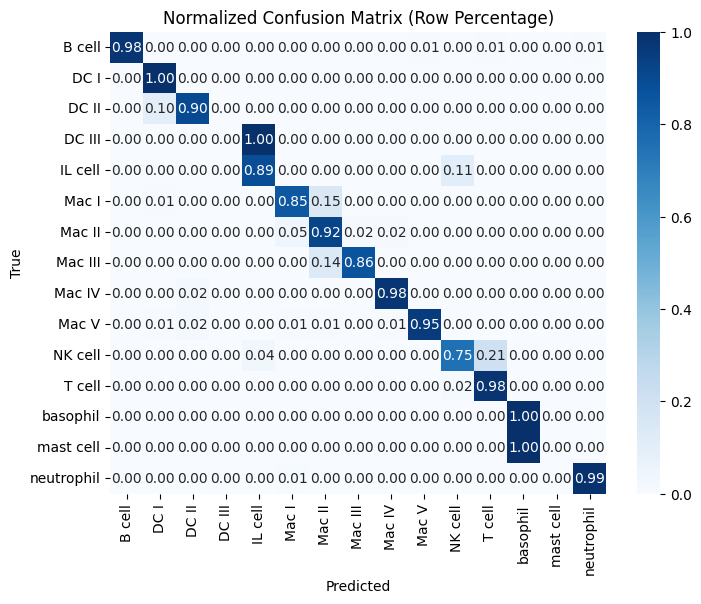

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(adata_test.obs[class_label], adata_test.obs["pred_0"])

# Normalize by row (convert counts to percentages)
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# Get all unique cell types
labels = sorted(adata_test.obs[class_label].unique())

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="Blues")

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Row Percentage)")
plt.show()

### **Step 5: View Explainability**

Interpreting machine learning models is critical, especially in biological research, where understanding why a model makes predictions can reveal important biological insights. SIMS uses TabNet's built-in explainability to identify which genes contribute most to its predictions.

The explainability matrix assigns an importance score to each gene based on how much it influenced the model's classification decisions. This allows us to determine the top contributing genes and assess whether they align with known biological markers.

#### `5.a` Generate the Explainability Matrix
We will use `sims.explain()` to compute feature importance scores for each gene. This produces an explainability matrix, where each value represents how much a specific gene contributed to the model’s classification decision for a given cell. We then convert it to a pandas DataFrame for easy manipulation and compute the average importance score for each gene across all cells.

In [37]:
# Run explainability analysis
explainability_matrix = sims.explain(adata_test, num_workers=0, batch_size=32)[0]

# Convert explainability matrix to a DataFrame
explain_df = pd.DataFrame(explainability_matrix, columns=sims.model.genes)

# Compute average gene importance
gene_importance = explain_df.mean(axis=0)

Computing explainability matrix ...


100%|██████████| 26/26 [00:02<00:00, 10.52it/s]


#### `5.b` View most influential genes
Now that we have computed gene importance scores, we can identify and print the top n most influential genes (the ones that contributed the most to the model’s classification decisions).

In [38]:

top10_genes = gene_importance.nlargest(10) # Can increase to top 20, 30, etc.
print("Top 10 most important genes:")
print(top10_genes)

Top 10 most important genes:
Lsr         1.061564
Ddx19b      0.953902
Bcas3os1    0.895592
Mgat5       0.885213
Snord32a    0.871906
Shtn1       0.844958
Otulin      0.811020
Ltn1        0.740239
Ear1        0.432400
Lsm5        0.336838
dtype: float64
